# How to Get Your Specialized Neural Networks on ImageNet in Minutes With OFA Networks

In this notebook, we will demonstrate 
- how to use pretrained specialized OFA sub-networks for efficient inference on diverse hardware platforms
- how to get new specialized neural networks on ImageNet with the OFA network within minutes.

**[Once-for-All (OFA)](https://github.com/mit-han-lab/once-for-all)** is an efficient AutoML technique
that decouples training from search.
Different sub-nets can directly grab weights from the OFA network without training.
Therefore, getting a new specialized neural network with the OFA network is highly efficient, incurring little computation cost.

![](https://hanlab.mit.edu/files/OnceForAll/figures/ofa_search_cost.png)

## 1. Preparation
Let's first install all the required packages:

In [1]:
print('Installing PyTorch...')
! pip install torch 1>/dev/null
print('Installing torchvision...')
! pip install torchvision 1>/dev/null
print('Installing numpy...')
! pip install numpy 1>/dev/null
# thop is a package for FLOPs computing.
print('Installing thop (FLOPs counter) ...')
! pip install thop 1>/dev/null
# ofa is a package containing training code, pretrained specialized models and inference code for the once-for-all networks.
print('Installing OFA...')
! pip install ofa 1>/dev/null
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip install tqdm 1>/dev/null
print('Installing matplotlib...')
! pip install matplotlib 1>/dev/null
print('All required packages have been successfully installed!')

Installing PyTorch...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing torchvision...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing numpy...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing thop (FLOPs counter) ...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing OFA...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing tqdm (progress bar) ...
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
Installing matplotlib...
You should consider upgrading via the '/home

Then, we can import the packages used in this tutorial:

In [2]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
import time
import random
import math
import copy
from matplotlib import pyplot as plt

from ofa.model_zoo import ofa_net
from ofa.utils import download_url

from accuracy_predictor import AccuracyPredictor
from flops_table import FLOPsTable
from latency_table import LatencyTable
from evolution_finder import EvolutionFinder
from imagenet_eval_helper import evaluate_ofa_subnet, evaluate_ofa_specialized

# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

Successfully imported all packages and configured random seed to 1!


Now it's time to determine which device to use for neural network inference in the rest of this tutorial. If your machine is equipped with GPU(s), we will use the GPU by default. Otherwise, we will use the CPU.

In [3]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using GPU.


Good! Now you have successfully configured the environment! It's time to import the **OFA network** for the following experiments.
The OFA network used in this tutorial is built upon MobileNetV3 with width multiplier 1.2, supporting elastic depth (2, 3, 4) per stage, elastic expand ratio (3, 4, 6), and elastic kernel size (3, 5 7) per block.

In [4]:
ofa_network = ofa_net('ofa_mbv3_d234_e346_k357_w1.2', pretrained=True)
print('The OFA Network is ready.')

The OFA Network is ready.


Now, let's build the ImageNet dataset and the corresponding dataloader. Notice that **if you're using the CPU,
we will skip ImageNet evaluation by default** since it will be very slow.
If you are using the GPU, in case you don't have the full dataset,
we will download a subset of ImageNet which contains 2,000 images (~250M) for testing.
If you do have the full ImageNet dataset on your machine, just specify it in `imagenet_data_path` and the downloading script will be skipped.

In [5]:
if cuda_available:
    # path to the ImageNet dataset
    print("Please input the path to the ImageNet dataset. (For this tutorial, please use `/home/ec2-user/SageMaker/ILSVRC2012/`)\n")
    imagenet_data_path = input()

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        os.makedirs(imagenet_data_path, exist_ok=True)
        download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
        ! cd data && unzip imagenet_1k 1>/dev/null && cd ..
        ! cp -r data/imagenet_1k/* $imagenet_data_path
        ! rm -rf data
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Please input the path to the ImageNet dataset. (For this tutorial, please use `/home/ec2-user/SageMaker/ILSVRC2012/`)

/home/ubuntu/0_datasets/data/ILSVRC2012_1k/
The ImageNet dataset files are ready.


Now you have configured the dataset. Let's build the dataloader for evaluation.
Again, this will be skipped if you are in a CPU environment.

In [8]:
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    # extra imagenet path
    # imagenet_data_path = '/home/ubuntu/0_datasets/data/ILSVRC2012'
    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            root=os.path.join(imagenet_data_path, 'val'),
            transform=build_val_transform(224)
        ),
        batch_size=250,  # test batch size
        shuffle=True,
        num_workers=16,  # number of workers for the data loader
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready.')
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

The ImageNet dataloader is ready.


## 2. Using Pretrained Specialized OFA Sub-Networks
![](https://hanlab.mit.edu/files/OnceForAll/figures/select_subnets.png)
The specialized OFA sub-networks are "small" networks sampled from the "big" OFA network as is indicated in the figure above.
The OFA network supports over $10^{19}$ sub-networks simultaneously, so that the deployment cost for multiple scenarios can be saved by 16$\times$ to 1300$\times$ under 40 deployment scenarios.
Now, let's play with some of the sub-networks through the following interactive command line prompt (**Notice that for CPU users, this will be skipped**).
We recommend you to try a smaller sub-network (e.g., the sub-network for pixel1 with 20ms inference latency constraint) so that it takes less time to evaluate the model on ImageNet.

In [9]:
if cuda_available:
    net_id = evaluate_ofa_specialized(imagenet_data_path, data_loader)
    print('Finished evaluating the pretrained sub-network: %s!' % net_id)
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Please select a hardware platform from ('pixel1', 'pixel2', 'note10', 'note8', 's7edge', 'lg-g8', '1080ti', 'v100', 'tx2', 'cpu', 'flops')!

flops
Now, please specify a FLOPs constraint for model specialization among [389, 482, 595] MFLOPs. (Please just input the number.) 

595


Downloading: "https://hanlab.mit.edu/files/OnceForAll/ofa_specialized/flops@595M_top1@80.0_finetune@75/net.config" to .torch/ofa_specialized/flops@595M_top1@80.0_finetune@75/net.config
Downloading: "https://hanlab.mit.edu/files/OnceForAll/ofa_specialized/flops@595M_top1@80.0_finetune@75/run.config" to .torch/ofa_specialized/flops@595M_top1@80.0_finetune@75/run.config
Downloading: "https://hanlab.mit.edu/files/OnceForAll/ofa_specialized/flops@595M_top1@80.0_finetune@75/init" to .torch/ofa_specialized/flops@595M_top1@80.0_finetune@75/init
Validate: 100%|██████████| 4/4 [00:04<00:00,  1.59s/it, loss=0.802, top1=81.1, top5=96.7, img_size=236]

Results: loss=0.80161,	 top1=81.1,	 top5=96.7
Finished evaluating the pretrained sub-network: flops@595M_top1@80.0_finetune@75!


## 3 Efficient Deployment with OFA Networks

You have now successfully prepared the whole environment for the experiment!
In the next step, we will introduce **how to get efficient, specialized neural networks within minutes**
powered by the OFA network.

### 3.1 Latency-Constrained Efficient Deployment on Samsung Note10

The key components of very fast neural network deployment are **accuracy predictors** and **efficiency predictors**.
For the accuracy predictor, it predicts the Top-1 accuracy of a given sub-network on a **holdout validation set**
(different from the official 50K validation set) so that we do **NOT** need to run very costly inference on ImageNet
while searching for specialized models. Such an accuracy predictor is trained using an accuracy dataset built with the OFA network.

![](https://hanlab.mit.edu/files/OnceForAll/figures/predictor_based_search.png)

In [10]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)

print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


Now, we have the powerful **accuracy predictor**. We then introduce two types of **efficiency predictors**: the latency predictor and the FLOPs predictor. 

The intuition of having efficiency predictors, especially the latency predictor, is that measuring the latency of a sub-network on-the-fly is also costly, especially for mobile devices.
The latency predictor is designed to eliminate this cost.
Let's load a latency predictor we built beforehand for the Samsung Note10.

In [11]:
target_hardware = 'note10'
latency_table = LatencyTable(device=target_hardware)
print('The Latency lookup table on %s is ready!' % target_hardware)

/home/ubuntu/2_workspace/nni_hpo/3rdparty/AutoGluon-Tutorial-CVPR2020/ofa-tutorial/latency_table.py:17: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.lut = yaml.load(fp)


Built latency table for image size: 160.
Built latency table for image size: 176.
Built latency table for image size: 192.
Built latency table for image size: 208.
Built latency table for image size: 224.
The Latency lookup table on note10 is ready!


So far, we have defined both the accuracy predictor and the latency predictor. Now, let's experience **very fast model specialization** on Samsung Note10 with these two powerful predictors! 

**Notice**: The predicted accuracy is on a holdout validation set of 10K images, not the official 50K validation set.
But they are highly positive-correlated.

In [12]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
params = {
    'constraint_type': target_hardware, # Let's do FLOPs-constrained search
    'efficiency_constraint': latency_constraint,
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': latency_table, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}

# build the evolution finder
finder = EvolutionFinder(**params)

# start searching
result_lis = []
st = time.time()
best_valids, best_info = finder.run_evolution_search()
result_lis.append(best_info)
ed = time.time()
print('Found best architecture on %s with latency <= %.2f ms in %.2f seconds! '
      'It achieves %.2f%s predicted accuracy with %.2f ms latency on %s.' %
      (target_hardware, latency_constraint, ed-st, best_info[0] * 100, '%', best_info[-1], target_hardware))

# visualize the architecture of the searched sub-net
_, net_config, latency = best_info
ofa_network.set_active_subnet(ks=net_config['ks'], d=net_config['d'], e=net_config['e'])
print('Architecture of the searched sub-net:')
print(ofa_network.module_str)

Searching with note10 constraint (25): 100%|██████████| 500/500 [00:20<00:00, 23.97it/s]

Found best architecture on note10 with latency <= 25.00 ms in 20.93 seconds! It achieves 81.71% predicted accuracy with 24.73 ms latency on note10.
Architecture of the searched sub-net:
3x3_Conv_O24
(3x3_MBConv1_RELU_O24, Identity)
((O32, E3.0, K5), None)
((O32, E3.0, K3), Identity)
(SE(O48, E4.0, K5), None)
(SE(O48, E4.0, K3), Identity)
((O96, E6.0, K7), None)
((O96, E3.0, K7), Identity)
((O96, E4.0, K3), Identity)
(SE(O136, E4.0, K5), None)
(SE(O136, E4.0, K5), Identity)
(SE(O136, E4.0, K7), Identity)
(SE(O136, E3.0, K3), Identity)
(SE(O192, E6.0, K3), None)
(SE(O192, E6.0, K3), Identity)
(SE(O192, E6.0, K5), Identity)
1x1_Conv_O1152
1x1_Conv_O1536
1536x1000_Linear



Great! You get your specialized neural network with **just a few seconds**!
You can go back to the last cell and modify the hyper-parameters to see how they affect the search time and the accuracy.

We also provided an interface below to draw a figure comparing your searched specialized network and other efficient neural networks such as MobileNetV3 and ProxylessNAS.

**Notice**: For ease of comparison, we recommend you to choose a latency constraint between 15ms and 33ms.

Evaluating the sub-network with latency = 24.7 ms on note10


Validate: 100%|██████████| 200/200 [01:36<00:00,  2.85it/s, loss=0.996, top1=76.9, top5=93.2, img_size=192]


Results: loss=0.99607,	 top1=76.9,	 top5=93.2


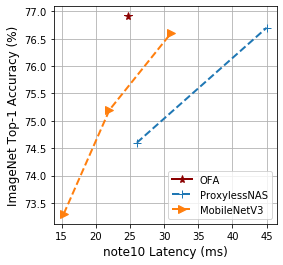

In [ ]:
# evaluate the searched model on ImageNet
if cuda_available:
    top1s = []
    latency_list = []
    for result in result_lis:
        _, net_config, latency = result
        print('Evaluating the sub-network with latency = %.1f ms on %s' % (latency, target_hardware))
        top1 = evaluate_ofa_subnet(
            ofa_network,
            imagenet_data_path,
            net_config,
            data_loader,
            batch_size=250,
            device='cuda:0' if cuda_available else 'cpu')
        top1s.append(top1)
        latency_list.append(latency)

    plt.figure(figsize=(4,4))
    plt.plot(latency_list, top1s, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
    plt.plot([26, 45], [74.6, 76.7], '--', marker='+', linewidth=2, markersize=8, label='ProxylessNAS')
    plt.plot([15.3, 22, 31], [73.3, 75.2, 76.6], '--', marker='>', linewidth=2, markersize=8, label='MobileNetV3')
    plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
    plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
    plt.legend(['OFA', 'ProxylessNAS', 'MobileNetV3'], loc='lower right')
    plt.grid(True)
    plt.show()
    print('Successfully draw the tradeoff curve!')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

**Notice:** You can further significantly improve the accuracy of the searched sub-net by fine-tuning it on the ImageNet training set.
Our results after fine-tuning for 25 epochs are as follows:
![](https://hanlab.mit.edu/files/OnceForAll/figures/diverse_hardware.png)


### 3.2 FLOPs-Constrained Efficient Deployment

Now, let's proceed to the final experiment of this tutorial: efficient deployment under FLOPs constraint. We use the same accuracy predictor since accuracy predictors are agnostic to the types of efficiency constraint (mobile latency / FLOPs). For the efficiency predictor, we change the latency lookup table to a flops lookup table. You can run the code below to setup it in a few seconds.

In [12]:
flops_lookup_table = FLOPsTable(
    device='cuda:0' if cuda_available else 'cpu',
    batch_size=1,
)
print('The FLOPs lookup table is ready!')

Building the flops lookup table (resolution=160)...
Built the flops lookup table (resolution=160)!
Building the flops lookup table (resolution=176)...
Built the flops lookup table (resolution=176)!
Building the flops lookup table (resolution=192)...
Built the flops lookup table (resolution=192)!
Building the flops lookup table (resolution=208)...
Built the flops lookup table (resolution=208)!
Building the flops lookup table (resolution=224)...
Built the flops lookup table (resolution=224)!
The FLOPs lookup table is ready!


Now, you can start a FLOPs-constrained neural architecture search. Here, we directly generate **an entire tradeoff curve** for you. Please notice that the time it takes to get each data point will get longer and longer (but always less than 30 seconds) because smaller FLOPs-constraint is more difficult to meet.

If you are using CPUs, you will be able to see a "predicted holdout validation set accuracy - FLOPs" tradeoff curve, which can be obtained in just a  minute.

If you are using GPUs, besides the curve mentioned above, we will also evaluate all the models you designed on the ImageNet validation set (**Again, it will be better if you have the full ImageNet validation set**, but it's also OK if you downloaded the subset above) and generate an "ImageNet 50K validation set accuracy - FLOPs" tradeoff curve. We will also plot competing methods such as ProxylessNAS, MobileNetV3, and EfficientNet in this curve for your reference. The estimated time to get the two curves is less than 10 minutes.

Please notice that it usually takes ** hundreds/thousands of hours** to generate an accuracy-FLOPs tradeoff curve for ProxylessNAS / MobileNetV3 / EfficientNet, but generating the tradeoff curve for our OFA takes just a few minutes, as you will experience soon.

Searching with flops constraint (350): 100%|██████████| 500/500 [00:12<00:00, 38.94it/s]


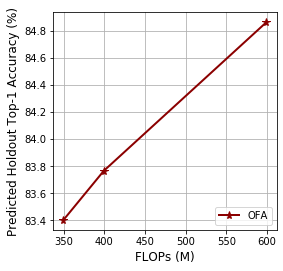

In [15]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
params = {
    'constraint_type': 'flops', # Let's do FLOPs-constrained search
    'efficiency_constraint': 600,  # FLops constraint (M), suggested range [150, 600]
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': flops_lookup_table, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}

# build the evolution finder
finder = EvolutionFinder(**params)

# start searching
result_lis = []
for flops in [600, 400, 350]:
    st = time.time()
    finder.set_efficiency_constraint(flops)
    best_valids, best_info = finder.run_evolution_search()
    ed = time.time()
    # print('Found best architecture at flops <= %.2f M in %.2f seconds! It achieves %.2f%s predicted accuracy with %.2f MFLOPs.' % (flops, ed-st, best_info[0] * 100, '%', best_info[-1]))
    result_lis.append(best_info)

plt.figure(figsize=(4,4))
plt.plot([x[-1] for x in result_lis], [x[0] * 100 for x in result_lis], 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
plt.xlabel('FLOPs (M)', size=12)
plt.ylabel('Predicted Holdout Top-1 Accuracy (%)', size=12)
plt.legend(['OFA'], loc='lower right')
plt.grid(True)
plt.show()

Let's evaluate the searched models on ImageNet if GPU is available:

Evaluating the sub-network with FLOPs = 599.1M


Validate: 100%|██████████| 200/200 [01:48<00:00,  1.85it/s, loss=0.906, top1=79.1, top5=94.5, img_size=224]


Results: loss=0.90586,	 top1=79.1,	 top5=94.5
---------------------------------------------
Evaluating the sub-network with FLOPs = 399.5M


Validate: 100%|██████████| 200/200 [01:41<00:00,  1.96it/s, loss=0.945, top1=78.3, top5=94.1, img_size=208]


Results: loss=0.94540,	 top1=78.3,	 top5=94.1
---------------------------------------------
Evaluating the sub-network with FLOPs = 349.9M


Validate: 100%|██████████| 200/200 [01:39<00:00,  2.00it/s, loss=0.954, top1=78.1, top5=94, img_size=208]  


Results: loss=0.95356,	 top1=78.1,	 top5=94.0
---------------------------------------------


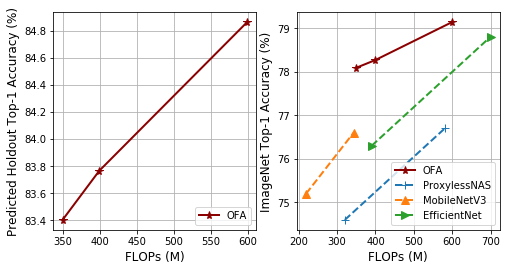

In [16]:
if cuda_available:
    # test the searched model on the test dataset (ImageNet val)
    top1s = []
    flops_lis = []
    for result in result_lis:
        _, net_config, flops = result
        print('Evaluating the sub-network with FLOPs = %.1fM' % flops)
        top1 = evaluate_ofa_subnet(
            ofa_network,
            imagenet_data_path,
            net_config,
            data_loader,
            batch_size=250,
            device='cuda:0' if cuda_available else 'cpu')
        print('-' * 45)
        top1s.append(top1)
        flops_lis.append(flops)

    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.plot([x[-1] for x in result_lis], [x[0] * 100 for x in result_lis], 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
    plt.xlabel('FLOPs (M)', size=12)
    plt.ylabel('Predicted Holdout Top-1 Accuracy (%)', size=12)
    plt.legend(['OFA'], loc='lower right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(flops_lis, top1s, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
    plt.plot([320, 581], [74.6, 76.7], '--', marker='+', linewidth=2, markersize=8, label='ProxylessNAS')
    plt.plot([219, 343], [75.2, 76.6], '--', marker='^', linewidth=2, markersize=8, label='MobileNetV3')
    plt.plot([390, 700], [76.3, 78.8], '--', marker='>', linewidth=2, markersize=8, label='EfficientNet')
    plt.xlabel('FLOPs (M)', size=12)
    plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
    plt.legend(['OFA', 'ProxylessNAS', 'MobileNetV3', 'EfficientNet'], loc='lower right')
    plt.grid(True)
    plt.show()

**Notice:** Again, you can further improve the accuracy of the search sub-net by fine-tuning it on ImageNet.
The final accuracy is much better than training the same architecture from scratch.
Our results are as follows:
![](https://hanlab.mit.edu/files/OnceForAll/figures/imagenet_80_acc.png)
![](https://hanlab.mit.edu/files/OnceForAll/figures/cnn_imagenet_new.png)

Congratulations! You've finished all the content of this tutorial!
Hope you enjoy playing with the OFA Networks. If you are interested,  please refer to our paper and GitHub Repo for further details.

## Reference
[1] CVPR'20 tutorial: **AutoML for TinyML with Once-for-All Network**. [[talk]](https://www.youtube.com/watch?v=fptQ_eJ3Uc0&feature=youtu.be).

[1] Han Cai, Chuang Gan, Tianzhe Wang, Zhekai Zhang and Song Han.
**Once for All: Train One Network and Specialize It for Efficient Deployment**. In *ICLR* 2020.
[[paper]](https://arxiv.org/abs/1908.09791), [[code]](https://github.com/mit-han-lab/once-for-all), [[talk]](https://www.youtube.com/watch?v=a_OeT8MXzWI).

[2] Han Cai, Ligeng Zhu and Song Han. **ProxylessNAS: Direct Neural Architecture Search on Target Task and Hardware**.
In *ICLR* 2019. [[paper]](https://arxiv.org/abs/1812.00332), [[code]](https://github.com/MIT-HAN-LAB/ProxylessNAS).
